   Copyright 2020 Erik Lee

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

In [ ]:
import os
import zipfile
import random
import shutil
from shutil import copyfile
import cv2.cv2 as cv2

import tensorflow as tf
import numpy as np
import matplotlib as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from stn import spatial_transformer_network as transformer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas
from tensorflow.keras.applications import InceptionV3

i_s = 128
tf.keras.backend.clear_session()
%precision 4

L2_WEIGHT_DECAY = 0.01

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(i_s,i_s,3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation="softmax")
    ])
model.summary()

In [ ]:
def identity_block(input_tensor, kernel_size, filters):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
    """
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)

    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    x = layers.BatchNormalization()(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the second conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """

    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)


    x = layers.Conv2D(filters2, kernel_size, strides=strides, padding='same',
                      use_bias=False, kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, use_bias=False,
                             kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(input_tensor)

    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def resnet50(num_classes, input_shape):
    img_input = layers.Input(shape=input_shape)


    x = img_input

    # Conv1 (7x7,64,stride=2)
    x = layers.ZeroPadding2D(padding=(3, 3))(x)

    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)

    # 3x3 max pool,stride=2
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Conv2_x

    # 1×1, 64
    # 3×3, 64
    # 1×1, 256

    x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])

    # Conv3_x
    #
    # 1×1, 128
    # 3×3, 128
    # 1×1, 512

    x = conv_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])

    # Conv4_x
    # 1×1, 256
    # 3×3, 256
    # 1×1, 1024
    x = conv_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])

    # 1×1, 512
    # 3×3, 512
    # 1×1, 2048
    x = conv_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])

    # average pool, 1000-d fc, softmax
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(
        num_classes, activation='softmax',
            bias_regularizer=regularizers.l2(L2_WEIGHT_DECAY),
            kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY))(x)

    # Create model.
    return models.Model(img_input, x, name='resnet50')

In [ ]:
model = resnet50(5, (i_s, i_s, 3))

In [ ]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
def convert_to_grayscale(img):
      return tf.image.rgb_to_grayscale(img, name=None)
# the preprocess function assumes 1 argument, the image, you do not need to add that inline
# validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=convert_to_grayscale,)

TRAINING_DIR = "emotions_5/train/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      vertical_flip=True)
      # rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, target_size=(i_s,i_s), 
batch_size=64, class_mode="categorical")

VALIDATION_DIR = "emotions_5/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=(i_s,i_s),batch_size=64, class_mode="categorical")



Bonnie_surprise_1389 image was corrupt, had to be removed

In [ ]:
check_points = "checkpoint/checkpoint.hb/"
check_point_dir = os.path.dirname(check_points)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_point_dir, verbose=1, monitor="val_acc", save_best_only=True)

In [ ]:
## Load checkpoint model
# model = tf.keras.models.load_model("checkpoint/checkpoint.hb/")

In [ ]:
history = model.fit(train_generator,
                            epochs=15,
                            verbose=1,  
                            validation_data=validation_generator,
                            callbacks=[cp_callback]) 

In [14]:
faceNet_dir = "faceNet\\3cnn_2dnn_no_regularization\\"

In [15]:
# Only Run this code if you want to overwrite the old model
# tf.saved_model.save(model, faceNet_dir)
# model.save("emotion_model.0_3cnn_2dns_input64x64.model")

In [16]:
## Load model
model = tf.keras.models.load_model(faceNet_dir)

In [17]:
test_dir = "emotions_5/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(i_s,i_s), 
batch_size=32, class_mode="categorical")

model.evaluate(test_generator)

Found 8083 images belonging to 5 classes.
253/253 [==============================] - 23s 91ms/step - loss: 0.8720 - acc: 0.7079


[0.8720, 0.7079]

In [18]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")



NameError: name 'history' is not defined

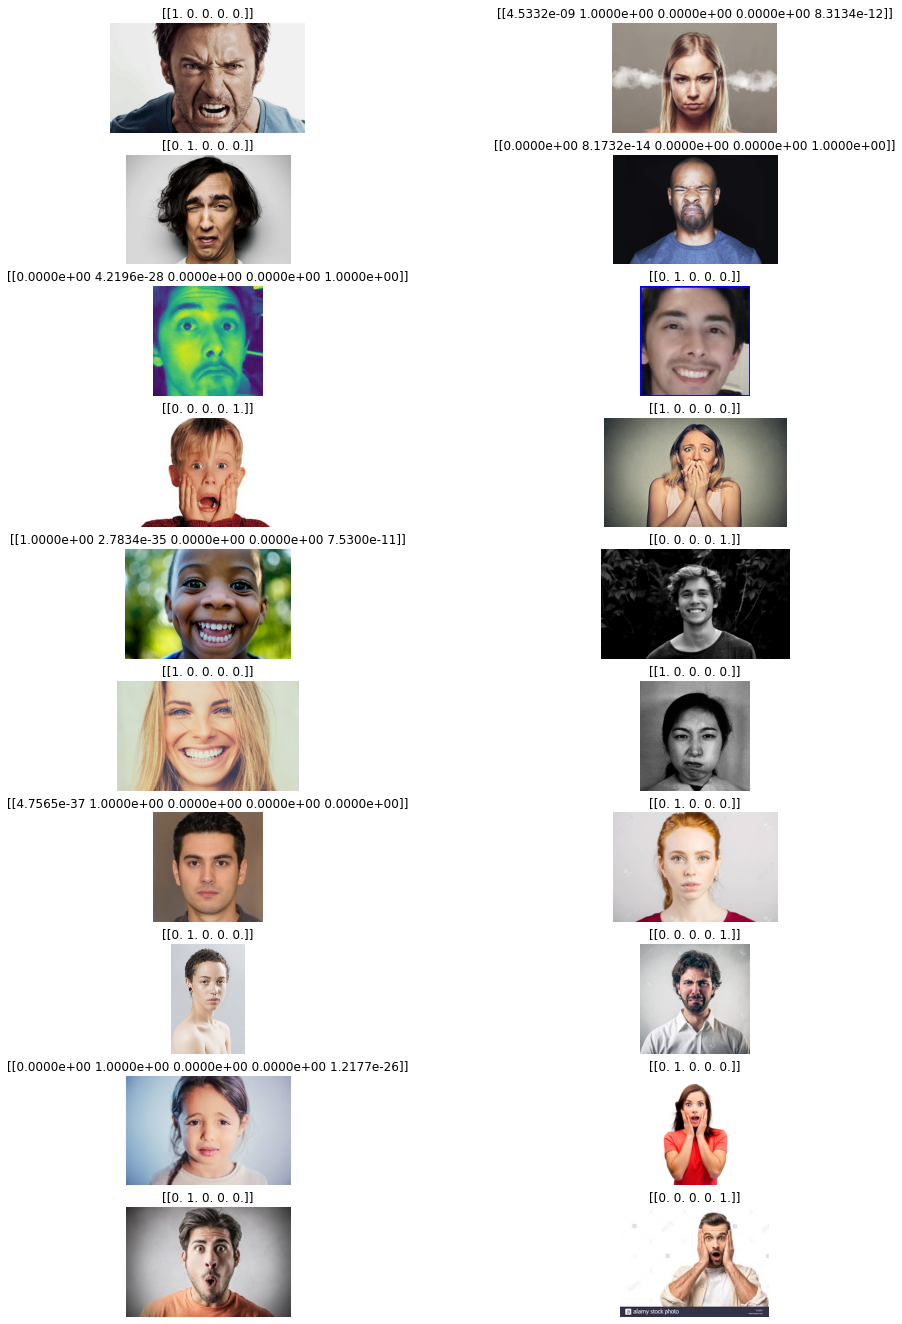

In [19]:
root_dir = "img_test"
dir_ = os.listdir(root_dir)

test_img_paths = [os.path.join(root_dir,x) for x in dir_]
rows = len(dir_)

fig = plt.gcf()
fig.set_size_inches(16,48)
for i, img in enumerate(test_img_paths):
    img_load_for_test = image.load_img(img, target_size=(i_s,i_s))
    img_test = image.img_to_array(img_load_for_test)
    img_test = np.expand_dims(img_test, axis=0)
    title = model.predict(img_test)

    img_plot = mpimg.imread(img)
    sb = plt.subplot(20,2,i+1)
    sb.set_title(str(title))
    sb.axis("off")
    img_plot = mpimg.imread(img)
    plt.imshow(img_plot)
plt.show()


In [ ]:

import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
abc = "emotions/test/anger"
abc_li = os.listdir(abc)
xyz = [os.path.join(abc, f) for f in abc_li]


img_path = random.choice(xyz)
img = load_img(img_path, target_size=(i_s, i_s))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
fig = plt.gcf()
fig.set_size_inches(16,48)
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis') 